---

## Imports

In [1]:
import pandas as pd
import numpy as np

import pickle
import wget, os
import time
import glob
import pytz

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
 
register_matplotlib_converters()
%matplotlib inline
sns.set_style('whitegrid')

In [3]:
# from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, r2_score

---

## Function Definitions

In [4]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [5]:
# From Matt Brems lecture

def MSE(true, predicted):
    squared_diff = np.square(true - predicted)
    return np.mean(squared_diff)

# Root Mean Square Error
def RMSE(true, predicted):
    squared_diff = np.square(true - predicted)    
    return np.sqrt(np.mean(squared_diff))

# R-squared, coefficient of determination
def R_squared(true, predicted):
    true      = np.array(true)
    predicted = np.array(predicted)
    sum_squared_diff = sum(np.square(true - predicted))
    variance  = sum(np.square(true - np.mean(true)))
    calc_r2   = 1 - (sum_squared_diff / variance)
    return calc_r2

---

## Load Pickles:  Train/Test Dataframes &  Full Dataframe

In [6]:
with open('../data/processed/train.pkl', 'rb') as f:
    train = pickle.load(f)
    
with open('../data/processed/test.pkl', 'rb') as f:
    test = pickle.load(f)
    
with open('../data/pre_processed_df.pkl', 'rb') as f:
    df = pickle.load(f)

---

## Augmented Dickey-Fuller Test

P-value for both target variables are **extremely** low (`1.4e-19` and `6.5e-28` for day-ahead and hour-ahead prices, respectively), so they both pass the the test for stationarity, assuming some low threshold for $\alpha$ such as 0.05 or 0.01  

Differencing is not required, so set `$d = 0$`.

In [7]:
interpret_dftest(adfuller(train['dam_price_per_mwh']))

Test Statistic   -1.086989e+01
p-value           1.377061e-19
dtype: float64

In [8]:
interpret_dftest(adfuller(train['hasp_price_per_mwh']))

Test Statistic   -1.516645e+01
p-value           6.481191e-28
dtype: float64

---

## Choose Values for `p` and `q`

 * Endogenous variable: **DA price** ... $p=1$ ... sharp cutoff in PACF bet. lag-1 & lag-2; ACF lag-1 > 0  
 * Endogenous variable: **DA price** ... $q=0$ ... ACF lag-1 is not negative  
 <br/>
 * Endogenous variable: **HA price** ... $p=1$ ... sharp cutoff in PACF bet. lag-1 & lag-2; ACF lag-1 > 0  
 * Endogenous variable: **HA price** ... $q=0$ ... ACF lag-1 is not negative  
 <br/>

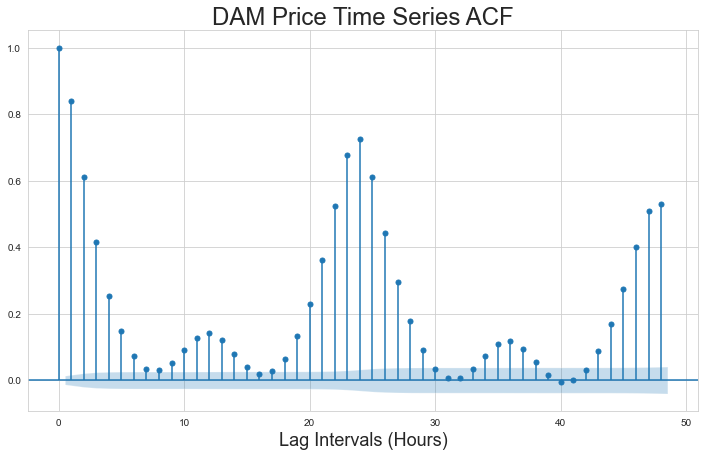

In [9]:
fig, ax = plt.subplots(figsize=(12,7))
plot_acf(train['dam_price_per_mwh'], lags=24*2, ax=ax)
plt.title('DAM Price Time Series ACF', fontsize=24)
plt.xlabel('Lag Intervals (Hours)', fontsize=18)
plt.savefig('../images/dam_acf.jpg')
plt.show();

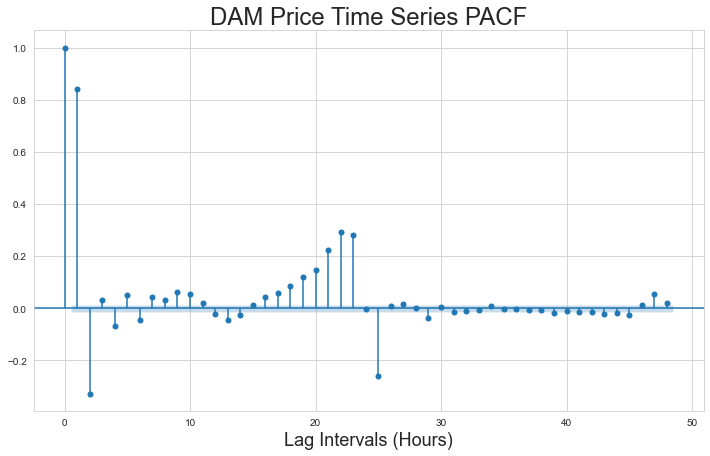

In [10]:
fig, ax = plt.subplots(figsize=(12,7))
plot_pacf(train['dam_price_per_mwh'], lags=24*2, ax=ax)
plt.title('DAM Price Time Series PACF', fontsize=24)
plt.xlabel('Lag Intervals (Hours)', fontsize=18)
plt.savefig('../images/dam_pacf.jpg')
plt.show();

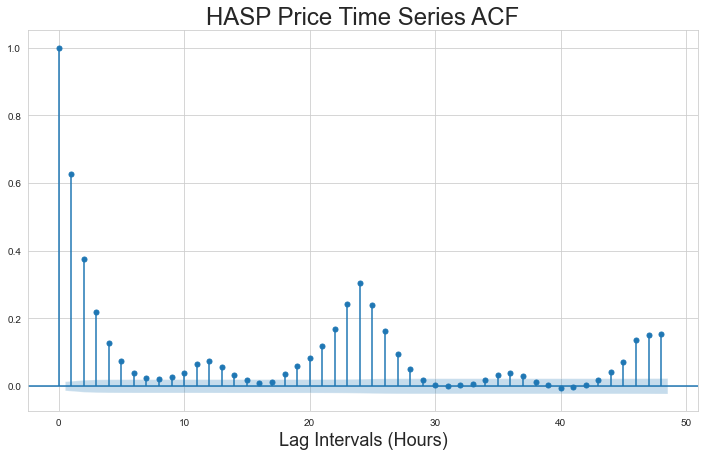

In [11]:
fig, ax = plt.subplots(figsize=(12,7))
plot_acf(train['hasp_price_per_mwh'], lags=24*2, ax=ax)
plt.title('HASP Price Time Series ACF', fontsize=24)
plt.xlabel('Lag Intervals (Hours)', fontsize=18)
plt.savefig('../images/hasp_acf.jpg')
plt.show();

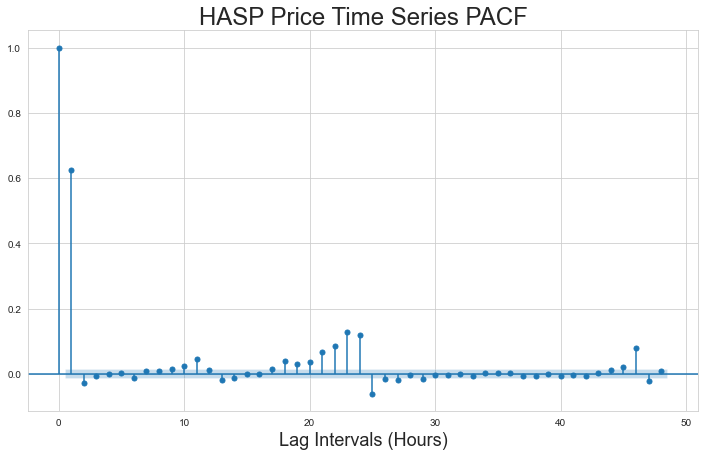

In [12]:
fig, ax = plt.subplots(figsize=(12,7))
plot_pacf(train['hasp_price_per_mwh'], lags=24*2, ax=ax)
plt.title('HASP Price Time Series PACF', fontsize=24)
plt.xlabel('Lag Intervals (Hours)', fontsize=18)
plt.savefig('../images/hasp_pacf.jpg')
plt.show();

---

## Gridsearch to find lowest MSE params for `p`, `d`, `q`

(for `DAM` and `HASP` prices as endogenous variables)



In [ ]:
# Matt Brem's grid search loop

for p in range(7):
    for d in range(7):
        for q in range(7):
            try:
                dam_arima = ARIMA(endog = train['dam_price_per_mwh'].astype('float32'), # Y variable
                              order = (p, d, q)) # (p, d, q)
                dam_model = dam_arima.fit()
                dam_preds = dam_model.predict()
                print(f'MSE for (p={p}, d={d}, q={q}) ... {mean_squared_error(train["dam_price_per_mwh"], dam_preds)}')
            
            except:
                pass

/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.44659D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   4.447D+00
  F =   4.4465871918505258     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
MSE for (p=0, d=0, q=0) ... 426.3656600600254
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exa

 This problem is unconstrained.



At iterate    5    f=  4.01634D+00    |proj g|=  1.68754D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7      9      1     0     0   0.000D+00   4.016D+00
  F =   4.0163393199580089     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
MSE for (p=0, d=0, q=1) ... 180.32417065991848
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88114D+00    |proj g|=  2.02061D-05


/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but 


At iterate    5    f=  3.88114D+00    |proj g|=  2.13163D-06

At iterate   10    f=  3.88114D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   8.882D-08   3.881D+00
  F =   3.8811401529032934     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
MSE for (p=0, d=0, q=2) ... 137.60004746359937
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.80472D+00    |proj g|=  2.44249D-05


/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but 


At iterate    5    f=  3.80472D+00    |proj g|=  1.77636D-06

At iterate   10    f=  3.80472D+00    |proj g|=  2.84217D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     19      1     0     0   0.000D+00   3.805D+00
  F =   3.8047236456173019     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
MSE for (p=0, d=0, q=3) ... 118.09720488415202
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.78469D+00    |proj g|=  2.32259D-05


/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but 


At iterate    5    f=  3.78469D+00    |proj g|=  9.76996D-07

At iterate   10    f=  3.78469D+00    |proj g|=  1.46549D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     18      1     0     0   8.882D-08   3.785D+00
  F =   3.7846878601588747     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
MSE for (p=0, d=0, q=4) ... 113.4581796701523
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77609D+00    |proj g|=  2.28262D-05


/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but 


At iterate    5    f=  3.77609D+00    |proj g|=  6.66134D-07

At iterate   10    f=  3.77609D+00    |proj g|=  1.06581D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     18      1     0     0   8.882D-08   3.776D+00
  F =   3.7760924396967952     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
MSE for (p=0, d=0, q=5) ... 111.52426158823575
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77216D+00    |proj g|=  2.25153D-05


/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but 


At iterate    5    f=  3.77216D+00    |proj g|=  1.24345D-06

At iterate   10    f=  3.77216D+00    |proj g|=  4.61853D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     14     20      1     0     0   1.776D-07   3.772D+00
  F =   3.7721597123755237     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
MSE for (p=0, d=0, q=6) ... 110.65041447886664
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.87451D+00    |proj g|=  0.00000D+00

           * * *

Tit 

/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.83400D+00    |proj g|=  7.19425D-06

At iterate    5    f=  3.83400D+00    |proj g|=  1.33227D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   1.332D-07   3.834D+00
  F =   3.8339998919179563     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77923D+00    |proj g|=  2.90434D-05

At iterate    5    f=  3.77923D+00    |proj g|=  4.81837D-05

At iterate   10    f=  3.77923D+00    |proj g|=  4.88498D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   0.000D+00   3.779D+00
  F =   3.7792309406580427     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76666D+00    |proj g|=  2.79776D-05

At iterate    5    f=  3.76666D+00    |proj g|=  4.78728D-05

At iterate   10    f=  3.76666D+00    |proj g|=  5.19584D-05

At iterate   15    f=  3.76666D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     22      1     0     0   8.882D-08   3.767D+00
  F =   3.7666632860088143     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76212D+00    |proj g|=  4.51195D-05

At iterate    5    f=  3.76212D+00    |proj g|=  3.33511D-05

At iterate   10    f=  3.76212D+00    |proj g|=  2.17604D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     13     19      1     0     0   8.882D-08   3.762D+00
  F =   3.7621153313696389     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodel

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09565D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   4.096D+00
  F =   4.0956516928127691     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.8

/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84151D+00    |proj g|=  1.23661D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      7      1     0     0   9.268D-04   3.842D+00
  F =   3.8415088257561409     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.83688D+00    |proj g|=  1.59879D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3      7      1     0     0   2.336D-05   3.837D+00
  F =   3.8368725002971145     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.83426D+00    |proj g|=  2.30446D+00


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  3.83425D+00    |proj g|=  1.06091D-02

At iterate   10    f=  3.83425D+00    |proj g|=  4.82290D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     51      2     0     0   6.492D-03   3.834D+00
  F =   3.8342544312393407     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77981D+00    |proj g|=  9.84698D+00


/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76730D+00    |proj g|=  9.32391D+00


 This problem is unconstrained.
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_m

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.83303D+00    |proj g|=  1.90514D-05

At iterate    5    f=  3.83303D+00    |proj g|=  1.50990D-06

At iterate   10    f=  3.83303D+00    |proj g|=  5.32907D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     22      1     0     0   4.441D-08   3.833D+00
  F =   3.8330315450993493     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
MSE for (p=1, d=0, q=0) ... 124.97718659654387


/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77623D+00    |proj g|=  2.02505D-05

At iterate    5    f=  3.77623D+00    |proj g|=  1.59872D-06

At iterate   10    f=  3.77623D+00    |proj g|=  1.28786D-06

At iterate   15    f=  3.77623D+00    |proj g|=  7.54952D-07

At iterate   20    f=  3.77623D+00    |proj g|=  1.06581D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     29      1     0     0   3.997D-07   3.776D+00
  F =   3.7762305064340267     

CONVERG

/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77100D+00    |proj g|=  2.29594D-05

At iterate    5    f=  3.77100D+00    |proj g|=  7.99361D-07

At iterate   10    f=  3.77100D+00    |proj g|=  7.10543D-07

At iterate   15    f=  3.77100D+00    |proj g|=  1.82077D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     26      1     0     0   4.441D-08   3.771D+00
  F =   3.7710031272495188     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
MSE for 

/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77097D+00    |proj g|=  2.26485D-05

At iterate    5    f=  3.77097D+00    |proj g|=  7.99361D-07

At iterate   10    f=  3.77097D+00    |proj g|=  4.44089D-07

At iterate   15    f=  3.77097D+00    |proj g|=  1.02141D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     25      1     0     0   1.332D-07   3.771D+00
  F =   3.7709668604089601     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
MSE for 

/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76583D+00    |proj g|=  1.68310D-05

At iterate    5    f=  3.76583D+00    |proj g|=  1.52323D-05

At iterate   10    f=  3.76583D+00    |proj g|=  8.74856D-06

At iterate   15    f=  3.76583D+00    |proj g|=  7.59393D-06

At iterate   20    f=  3.76583D+00    |proj g|=  2.98428D-05

At iterate   25    f=  3.76583D+00    |proj g|=  1.33227D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     30      1     0     0   

/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76144D+00    |proj g|=  1.70086D-05


 This problem is unconstrained.



At iterate    5    f=  3.76144D+00    |proj g|=  6.75016D-06

At iterate   10    f=  3.76144D+00    |proj g|=  4.24549D-05

At iterate   15    f=  3.76144D+00    |proj g|=  1.11022D-06

At iterate   20    f=  3.76144D+00    |proj g|=  3.42393D-05

At iterate   25    f=  3.76144D+00    |proj g|=  1.33227D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     26     30      1     0     0   8.882D-08   3.761D+00
  F =   3.7614356469542023     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
MSE for (p=1, d=0, q=6) ... 108.29985880559768
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2

/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.82941D+00    |proj g|=  4.11937D-04

At iterate    5    f=  3.82941D+00    |proj g|=  8.00249D-05

At iterate   10    f=  3.82941D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     17      1     0     0   1.332D-07   3.829D+00
  F =   3.8294094632037350     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76975D+00    |proj g|=  1.83320D-04


 This problem is unconstrained.



At iterate    5    f=  3.76975D+00    |proj g|=  1.04672D-04

At iterate   10    f=  3.76975D+00    |proj g|=  4.46576D-04

At iterate   15    f=  3.76975D+00    |proj g|=  4.44089D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     28      1     0     0   4.441D-08   3.770D+00
  F =   3.7697506798879932     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76863D+00    |proj g|=  1.50902D-04

At iterate    5    f=  3.76863D+00    |proj g|=  9.47242D-05

At iterate   10    f=  3.76863D+00    |proj g|=  6.53699D-05

At iterate   15    f=  3.76863D+00    |proj g|=  1.73195D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     24      1     0     0   1.066D-06   3.769D+00
  F =   3.7686332124355668     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76137D+00    |proj g|=  8.96616D-05

At iterate    5    f=  3.76137D+00    |proj g|=  3.93907D-05

At iterate   10    f=  3.76137D+00    |proj g|=  2.60680D-05


/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76082D+00    |proj g|=  8.45546D-05


/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.05167D+00    |proj g|=  6.66134D-06

At iterate    5    f=  4.05167D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      9      1     0     0   2.665D-07   4.052D+00
  F =   4.0516731805812736     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [ ]:
# Matt Brem's grid search loop

for p in range(7):
    for d in range(7):
        for q in range(7):
            try:
                hasp_arima = ARIMA(endog = train['hasp_price_per_mwh'].astype('float32'), # Y variable
                              order = (p, d, q)) # (p, d, q)
                hasp_model = hasp_arima.fit()
                hasp_preds = hasp_model.predict()
                print(f'MSE for (p={p}, d={d}, q={q}) ... {mean_squared_error(train["hasp_price_per_mwh"], hasp_preds):.2f}')
            
            except:
                pass

---

## Instantiate and Fit ARIMA for Day Ahead with 4, 0, 6 as Params

In [13]:
p = 4
d = 0
q = 6

dam_arima406 = ARIMA(endog = train['dam_price_per_mwh'].astype('float32'),  # Y variable
                     order = (p, d, q))                                     # (p, d, q)

dam_arima406_model = dam_arima406.fit()

/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72778D+00    |proj g|=  6.95235D-03


 This problem is unconstrained.



At iterate    5    f=  3.72777D+00    |proj g|=  7.20997D-03
  ys=-3.501E-11  -gs= 1.638E-11 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f=  3.72777D+00    |proj g|=  8.28981D-03

At iterate   15    f=  3.72777D+00    |proj g|=  1.44670D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f=  3.72777D+00    |proj g|=  5.60987D-03

At iterate   25    f=  3.72777D+00    |proj g|=  9.70704D-03
  ys=-6.894E-06  -gs= 2.452E-06 BFGS update SKIPPED

At iterate   30    f=  3.72777D+00    |proj g|=  6.91562D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  3.72777D+00    |proj g|=  6.94333D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  3.72777D+00    |proj g|=  5.31859D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f=  3.72777D+00    |proj g|=  1.02345D-02

At iterate   50    f=  3.72777D+00    |proj g|=  6.62892D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   55    f=  3.72777D+00    |proj g|=  6.21503D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   60    f=  3.72777D+00    |proj g|=  9.71143D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     61    495     10     2     0   9.711D-03   3.728D+00
  F =   3.7277713665154444     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after 20 function
  and gradient evaluations.  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
dam_arima406_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:      dam_price_per_mwh   No. Observations:                21800
Model:                     ARMA(4, 6)   Log Likelihood              -81265.416
Method:                       css-mle   S.D. of innovations             10.062
Date:                Thu, 16 Jun 2022   AIC                         162554.832
Time:                        20:12:09   BIC                         162650.708
Sample:                             0   HQIC                        162586.069
                                                                              
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      32.6651      1.401     23.320      0.000      29.920      35.410
ar.L1.dam_price_per_mwh     3.3263      0.009    351.716      0.000       3.308       3.345
ar.L2.dam_price_per_mwh    -4.3592      0.026   -170.243      0.000      -4.409      -4.309
ar.L3.dam_price_per_mwh     2.6309      0.025    103.419      0.000       2.581       2.681
ar.L4.dam_price_per_mwh    -0.5984      0.009    -64.633      0.000      -0.617      -0.580
ma.L1.dam_price_per_mwh    -2.2654      0.017   -130.470      0.000      -2.299      -2.231
ma.L2.dam_price_per_mwh     1.5811      0.043     37.147      0.000       1.498       1.665
ma.L3.dam_price_per_mwh     0.0550      0.035      1.563      0.118      -0.014       0.124
ma.L4.dam_price_per_mwh    -0.4281      0.021    -20.176      0.000      -0.470      -0.386
ma.L5.dam_price_per_mwh     0.1428      0.024      6.046      0.000       0.096       0.189
ma.L6.dam_price_per_mwh    -0.0773      0.009     -8.910      0.000      -0.094      -0.060
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8661           -0.5024j            1.0013           -0.0837
AR.2            0.8661           +0.5024j            1.0013            0.0837
AR.3            1.0036           -0.0000j            1.0036           -0.0000
AR.4            1.6609           -0.0000j            1.6609           -0.0000
MA.1            1.0194           -0.0000j            1.0194           -0.0000
MA.2            0.8759           -0.5064j            1.0118           -0.0834
MA.3            0.8759           +0.5064j            1.0118            0.0834
MA.4           -1.8031           -0.0000j            1.8031           -0.5000
MA.5            0.4389           -2.5846j            2.6216           -0.2232
MA.6            0.4389           +2.5846j            2.6216            0.2232
-----------------------------------------------------------------------------
"""

In [15]:
print(f'df:     {df.shape[0]}')
print(f'train:  {train.shape[0]}')
print(f'test:   {test.shape[0]}')
print(f'trn+tst:{train.shape[0] + test.shape[0]}')

df:     29067
train:  21800
test:   7267
trn+tst:29067


In [16]:
dam_arima406_train_preds = dam_arima406_model.predict(start= 0,
                                                      end  = train.shape[0]-1)
print(f'MSE  Train ARIMA({p},{d},{q}) ... \
{mean_squared_error(train["dam_price_per_mwh"], dam_arima406_train_preds):.2f}')
      
print(f'R-sq Train ARIMA({p},{d},{q}) ... \
{r2_score(train["dam_price_per_mwh"], dam_arima406_train_preds):.4f}')

MSE  Train ARIMA(4,0,6) ... 101.24
R-sq Train ARIMA(4,0,6) ... 0.7626


In [17]:
dam_arima406_test_preds = dam_arima406_model.predict(start = train.shape[0],
                                                     end   = df.shape[0]-1)
print(f'MSE  Test ARIMA({p},{d},{q}) ... \
{mean_squared_error(test["dam_price_per_mwh"], dam_arima406_test_preds):.2f}')
      
print(f'R-sq Test ARIMA({p},{d},{q}) ... \
{r2_score(test["dam_price_per_mwh"], dam_arima406_test_preds):.4f}')

MSE  Test ARIMA(4,0,6) ... 1693.05
R-sq Test ARIMA(4,0,6) ... -0.1734


/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [18]:
dam_arima406_train_resid = train["dam_price_per_mwh"] - dam_arima406_train_preds
dam_arima406_test_resid = test["dam_price_per_mwh"] - dam_arima406_test_preds

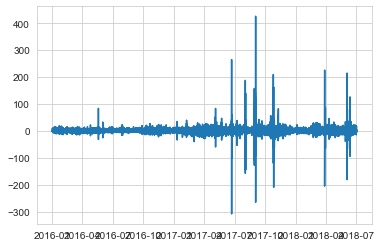

In [19]:
plt.plot(dam_arima406_train_resid);

In [20]:
with open('../fitted_models/dam_arima406_model.pkl', 'wb') as f:
    pickle.dump(dam_arima406_model, f)
    
with open('../data/predictions/dam_arima406_train_preds.pkl', 'wb') as f:
    pickle.dump(dam_arima406_train_preds, f)
    
with open('../data/predictions/dam_arima406_test_preds.pkl', 'wb') as f:
    pickle.dump(dam_arima406_test_preds, f)

---

## Instantiate and Fit ARIMA for Hour Ahead with 6, 0, 6 as Params

In [21]:
x = 6
y = 0
z = 6

hasp_arima606 = ARIMA(endog = train['hasp_price_per_mwh'].astype('float32'),  # Y variable
                     order = (x, y, z))                                     # (p, d, q)

hasp_arima606_model = hasp_arima606.fit()

/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.86847D+00    |proj g|=  8.68550D-04

At iterate    5    f=  4.86847D+00    |proj g|=  4.22862D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f=  4.86847D+00    |proj g|=  7.36655D-04

At iterate   15    f=  4.86847D+00    |proj g|=  3.29248D-04

At iterate   20    f=  4.86847D+00    |proj g|=  5.53158D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f=  4.86847D+00    |proj g|=  4.26326D-04

At iterate   30    f=  4.86847D+00    |proj g|=  8.24318D-04

At iterate   35    f=  4.86847D+00    |proj g|=  1.03269D-03
  ys=-1.282E-09  -gs= 4.475E-08 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  4.86847D+00    |proj g|=  2.77378D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f=  4.86847D+00    |proj g|=  5.29976D-04

At iterate   50    f=  4.86847D+00    |proj g|=  7.24931D-04
  ys=-7.492E-09  -gs= 2.286E-08 BFGS update SKIPPED
  ys=-6.202E-13  -gs= 4.372E-13 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   55    f=  4.86847D+00    |proj g|=  5.99432D-04

At iterate   60    f=  4.86847D+00    |proj g|=  4.70823D-04

At iterate   65    f=  4.86847D+00    |proj g|=  6.65779D-04

At iterate   70    f=  4.86847D+00    |proj g|=  1.66533D-04

At iterate   75    f=  4.86847D+00    |proj g|=  4.21974D-04

At iterate   80    f=  4.86847D+00    |proj g|=  4.44711D-04

At iterate   85    f=  4.86847D+00    |proj g|=  4.25349D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   90    f=  4.86847D+00    |proj g|=  3.54117D-04

At iterate   95    f=  4.86847D+00    |proj g|=  2.72049D-04

At iterate  100    f=  4.86847D+00    |proj g|=  2.62812D-04
  ys=-2.327E-15  -gs= 8.230E-15 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after 20 function
  and gradient evaluations.  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13    103    445      8     4     0   5.807D-04   4.868D+00
  F =   4.8684729521597339     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [22]:
hasp_arima606_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:     hasp_price_per_mwh   No. Observations:                21800
Model:                     ARMA(6, 6)   Log Likelihood             -106132.710
Method:                       css-mle   S.D. of innovations             31.484
Date:                Thu, 16 Jun 2022   AIC                         212293.421
Time:                        20:15:44   BIC                         212405.276
Sample:                             0   HQIC                        212329.864
                                                                              
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       32.4800      2.423     13.403      0.000      27.730      37.230
ar.L1.hasp_price_per_mwh     2.4366      0.010    233.108      0.000       2.416       2.457
ar.L2.hasp_price_per_mwh    -2.4365      0.023   -105.741      0.000      -2.482      -2.391
ar.L3.hasp_price_per_mwh     2.1233      0.030     70.320      0.000       2.064       2.182
ar.L4.hasp_price_per_mwh    -2.5629      0.035    -73.330      0.000      -2.631      -2.494
ar.L5.hasp_price_per_mwh     1.9796      0.025     77.783      0.000       1.930       2.029
ar.L6.hasp_price_per_mwh    -0.5405      0.010    -56.798      0.000      -0.559      -0.522
ma.L1.hasp_price_per_mwh    -1.8169      0.012   -147.671      0.000      -1.841      -1.793
ma.L2.hasp_price_per_mwh     1.2901      0.024     53.829      0.000       1.243       1.337
ma.L3.hasp_price_per_mwh    -1.2930      0.025    -52.354      0.000      -1.341      -1.245
ma.L4.hasp_price_per_mwh     1.7372      0.026     67.728      0.000       1.687       1.787
ma.L5.hasp_price_per_mwh    -0.8568      0.022    -38.740      0.000      -0.900      -0.813
ma.L6.hasp_price_per_mwh    -0.0551      0.010     -5.265      0.000      -0.076      -0.035
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.4341           -0.9150j            1.0127           -0.3205
AR.2           -0.4341           +0.9150j            1.0127            0.3205
AR.3            0.8660           -0.5023j            1.0011           -0.0837
AR.4            0.8660           +0.5023j            1.0011            0.0837
AR.5            1.0014           -0.0000j            1.0014           -0.0000
AR.6            1.7973           -0.0000j            1.7973           -0.0000
MA.1           -0.4289           -0.9153j            1.0108           -0.3197
MA.2           -0.4289           +0.9153j            1.0108            0.3197
MA.3            0.8703           -0.5041j            1.0058           -0.0836
MA.4            0.8703           +0.5041j            1.0058            0.0836
MA.5            1.0069           -0.0000j            1.0069           -0.0000
MA.6          -17.4344           -0.0000j           17.4344           -0.5000
-----------------------------------------------------------------------------
"""

In [23]:
hasp_arima606_train_preds = hasp_arima606_model.predict(start= 0,
                                                      end  = train.shape[0]-1)
print(f'MSE  Train ARIMA({x},{y},{z}) ... \
{MSE(train["hasp_price_per_mwh"], hasp_arima606_train_preds):.2f}')
      
print(f'R-sq Train ARIMA({x},{y},{z}) ... \
{R_squared(train["hasp_price_per_mwh"], hasp_arima606_train_preds):.4f}')

MSE  Train ARIMA(6,0,6) ... 991.25
R-sq Train ARIMA(6,0,6) ... 0.4091


In [24]:
hasp_arima606_test_preds = hasp_arima606_model.predict(start = train.shape[0],
                                                    end   = df.shape[0]-1)
print(f'MSE  Test ARIMA({x},{y},{z}) ... \
{MSE(test["hasp_price_per_mwh"], hasp_arima606_test_preds):.2f}')
      
print(f'R-sq Test ARIMA({x},{y},{z}) ... \
{R_squared(test["hasp_price_per_mwh"], hasp_arima606_test_preds):.4f}')

MSE  Test ARIMA(6,0,6) ... nan
R-sq Test ARIMA(6,0,6) ... -0.1380


/Users/Mehrdadi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [25]:
with open('../fitted_models/hasp_arima606_model.pkl', 'wb') as f:
    pickle.dump(hasp_arima606_model, f)
    
with open('../data/predictions/hasp_arima606_train_preds.pkl', 'wb') as f:
    pickle.dump(hasp_arima606_train_preds, f)
    
with open('../data/predictions/hasp_arima606_test_preds.pkl', 'wb') as f:
    pickle.dump(hasp_arima606_test_preds, f)